In [2]:
import sys
sys.path.append("../scripts")
import numerics
import matplotlib.pyplot as plt
import numpy as np
import style

In [3]:
"""
find_fps function modified from 'numerics' to handle inputs
"""


def find_fps(T, V, inputs, T_run, N_batch, dt=0.1, init_size=1000, return_full=False):
    P = T.shape[0]
    Nt = int(T_run / dt)
    S_series = np.zeros((Nt, N_batch, P, P))
    S_series[0] = np.random.uniform(-init_size, init_size, size=(N_batch, P, P))
    
    for i in range(1, Nt):
        t = i * dt
        input_t = inputs(t)
        
        # Compute Frobenius norm of S
        S_norm_sq = (S_series[i-1]**2).sum(axis=-1)
        
        # Compute Psi with Frobenius norm and squared input
        psi = numerics.compute_psi(S_norm_sq + (input_t**2)[None, :])
        
        # Compute T*S term with additional V input term
        TS_term = np.einsum('mnr,bn,bnr->bmn', T, psi, S_series[i-1], optimize='optimal')
        V_input_term = np.einsum('mn,n->mn', V, input_t, optimize='optimal')[None, :, :]
        combined_term = TS_term + V_input_term
        
        S_series[i] = S_series[i-1] + dt*(-S_series[i-1] + combined_term)
    
    S_fps = S_series[-1].copy()
    print(np.max(np.abs(S_series[-1] - S_series[-200])), flush=True)
    
    if return_full:
        return S_series
    else:
        return S_fps


In [4]:
P = 5

a = np.array([2.56497381, 1.97552974, 1.97887313, 1.95708126, 2.03461631])
b = np.array([1.90793845, 2.56979247, 2.46955172, 2.51276156, 2.49002518])

U = np.array([np.eye(P) for _ in range(P)])
V = np.zeros((P, P))
V[1:, 0] = 0.1

h = a - b
u = np.random.choice([-1.,1.], size=5)*np.sqrt(b)
T = numerics.make_T_from_uh(u, h)



In [5]:
input_strength = 0
inputs = lambda t: np.array([input_strength, 0, 0, 0, 0])
S1 = find_fps(T=T, V=V, inputs=inputs, T_run=2000, N_batch=1, init_size=1, dt=0.1)[0]

input_strength = 2
inputs = lambda t: np.array([input_strength, 0, 0, 0, 0])
S2 = find_fps(T=T, V=V, inputs=inputs, T_run=2000, N_batch=1, init_size=1, dt=0.1)[0]

1.2069359480676994e-119
2.833854919132176e-117


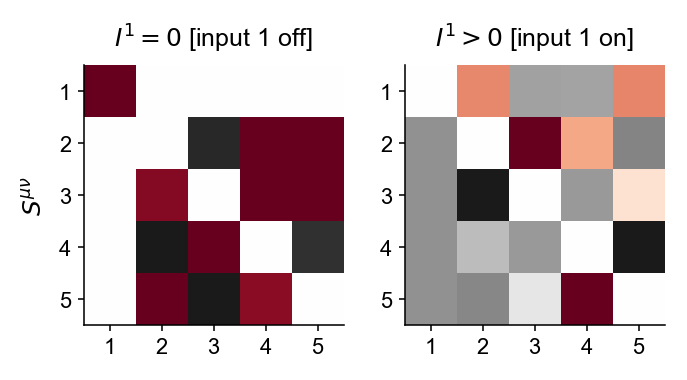

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(3.375, 1.5))
ax1, ax2 = axes

ax1.imshow(S1, vmin=-1, vmax=1, cmap='RdGy', interpolation="None")
ax2.imshow(S2, vmin=-1, vmax=1, cmap='RdGy', interpolation="None")
for ax in axes:
    ax.set_aspect(1.)
    t, tl = np.arange(5), [str(v) for v in np.arange(5)+1]
    ax.set_xticks(t, tl)
    ax.set_yticks(t, tl)

ax1.set_title("$I^1 = 0$ [input 1 off]")
ax2.set_title("$I^1 > 0$ [input 1 on]")
ax1.set_ylabel("$S^{\\mu\\nu}$")
#plt.savefig("figs/input_flip.png", bbox_inches='tight', dpi=450)
plt.show()